# Metis Project 1 - MTA Exploratory Data Analysis

MTA would like to introduce new experimental advertising panels at their stations. First 10 systems will be installed in September 2022, which seems to be perfect timing to reach Christmas buyers.
MTA representatives contacted me to identify 10 stations that could fully show potential of new advertising medium during September - December period.



# DATA PREPARATION

In [2]:
#Importing libraries

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sqlalchemy as db
from sqlalchemy import create_engine

%matplotlib inline


In [3]:
#Importing turnstile data from SQL database with SQLAlchemy

engine = create_engine("sqlite:///mta_data.db")

turnstiles_df = pd.read_sql('SELECT * FROM mta_data;', engine)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,00:00:00,REGULAR,7714568,2706545
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,04:00:00,REGULAR,7714583,2706554
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,08:00:00,REGULAR,7714590,2706575
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,12:00:00,REGULAR,7714641,2706648
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,16:00:00,REGULAR,7714728,2706690


##PREVIOUSLY USED BACKUP METHOD - Importing turnstile data from SQL database

conn = sqlite3.connect('mta_data.db') 
          
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM mta_data
                               ''', conn)

turnstiles_df = pd.DataFrame(sql_query, columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES'])

turnstiles_df.head()


#PREVIOUSLY USED BACKUP METHOD - Downloading turnstile data directly

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190907, 190914, 190921, 190928, 191005, 191012, 191019, 191026, 191102, 191109, 191116, 191123, 191130, 191207, 191214, 191221, 191228, 210904, 210911, 210918, 210925, 211002, 211009,211016, 211023, 211106, 211113, 211120, 211127, 211204, 211211, 211218, 211225, 220101, 220108, 220115, 220122, 220129, 220205, 220212, 220219, 220226, 220305, 220312, 220319, 220326, 220402, 220409, 220416, 220423, 220430, 220507, 220514, 220521, 220528]

turnstiles_df = get_data(week_nums)


To clean MTA code I use methods provided in this course, with small adjustments.

In [4]:
#Cleaning columns names

turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]


In [5]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,00:00:00,REGULAR,7714568,2706545
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,04:00:00,REGULAR,7714583,2706554
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,08:00:00,REGULAR,7714590,2706575
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,12:00:00,REGULAR,7714641,2706648
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,16:00:00,REGULAR,7714728,2706690


In [6]:
#Extracting and reformating DATE and TIME columns to datetime format

turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

turnstiles_df["DATE"] = pd.to_datetime(turnstiles_df.DATE, 
                                            format="%m/%d/%Y")


In [7]:
#Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique (ENRIES)

(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
11609960,S101,R070,00-00-02,ST. GEORGE,2021-09-27 08:00:00,2
9602928,R285,R308,00-00-00,MT EDEN AV,2019-11-06 07:00:00,2
9602930,R285,R308,00-00-00,MT EDEN AV,2019-11-06 15:00:00,2
9602931,R285,R308,00-00-00,MT EDEN AV,2019-11-06 19:00:00,2
9602932,R285,R308,00-00-00,MT EDEN AV,2019-11-06 23:00:00,2


In [8]:
#Checking specific case to better understand the problem

mask = ((turnstiles_df["C/A"] == "S101") & 
(turnstiles_df["UNIT"] == "R070") & 
(turnstiles_df["SCP"] == "00-00-02") & 
(turnstiles_df["STATION"] == "ST. GEORGE") &
(turnstiles_df["DATE_TIME"].dt.date == dt.datetime(2021, 9, 3).date()))

turnstiles_df[mask].head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
8200149,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,00:00:00,REGULAR,1396478,324,2021-09-03 00:00:00
8200150,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,00:00:00,RECOVR AUD,1213528,140,2021-09-03 00:00:00
8200151,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,04:00:00,REGULAR,1396480,324,2021-09-03 04:00:00
8200152,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,08:00:00,REGULAR,1396536,324,2021-09-03 08:00:00
8200153,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,08:00:00,RECOVR AUD,1213576,140,2021-09-03 08:00:00


In [9]:
#Dropping the duplicate entries

turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)


In [10]:
#Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique (ENRIES)

(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31 00:00:00,1
7802070,R141,R031,00-00-00,34 ST-PENN STA,2022-01-21 15:00:00,1
7802050,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 07:00:00,1
7802051,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 11:00:00,1
7802052,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 15:00:00,1


In [11]:
# Droping Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored

turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")


In [12]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATE_TIME
211706,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,21:00:00,0,2022-05-27 21:00:00
211705,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,17:00:00,0,2022-05-27 17:00:00
211704,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,13:00:00,0,2022-05-27 13:00:00
211703,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,09:00:00,0,2022-05-27 09:00:00
211702,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,05:00:00,0,2022-05-27 05:00:00


In [13]:
#Finding daily ENTRIES as a base for calculations, grabbing the highest reading of the day

turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.max())


In [14]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31,7183842
1,A002,R051,02-00-00,59 ST,2019-09-01,7184559
2,A002,R051,02-00-00,59 ST,2019-09-02,7185132
3,A002,R051,02-00-00,59 ST,2019-09-03,7186355
4,A002,R051,02-00-00,59 ST,2019-09-04,7187672


In [15]:
#Creating columns with previous date and entries number. As entries records are cumulative, those columns will be used to establish daily entry anjustment.

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",]
                                                       .apply(lambda grp: grp.shift(1)))


/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_14243/1050101385.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [16]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31,7183842,NaT,NaN
1,A002,R051,02-00-00,59 ST,2019-09-01,7184559,2019-08-31,7183842.0
2,A002,R051,02-00-00,59 ST,2019-09-02,7185132,2019-09-01,7184559.0
3,A002,R051,02-00-00,59 ST,2019-09-03,7186355,2019-09-02,7185132.0
4,A002,R051,02-00-00,59 ST,2019-09-04,7187672,2019-09-03,7186355.0


In [17]:
#Dropping the rows with the earliest date in the df

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [18]:
#Calculating entries, fixing negative counts, and ones over 50000, getting diference between entries count and entries count from day before

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=50000)


7626348 7324242.0
6746178 6508305.0
1450177 1334382.0
1642635 1368971.0
65458 6453765.0
6184029 5975986.0
7610958 7377194.0
12225136 11805752.0
9521670 9239637.0
524476 39.0
2595 130794.0
191003 26624.0
4521868 4179194.0
5611274 5328759.0
6575364 6384816.0
3309874 3166336.0
98114 7836799.0
101599 9370608.0
761225 500227.0
1195348 829728.0
262144 0.0
758113 677511.0
119818878 119572304.0
5207293 5059369.0
148722 7737249.0
5198702 4798335.0
15726007 15479061.0
280 15855093.0
11498335 11307447.0
157 11599257.0
3906489 3734771.0
169 3985295.0
4885158 4648191.0
2375312 2019643.0
20015882 19479610.0
4205464 3114820.0
506122 401537.0
752114 580212.0
307 836725.0
762358 598772.0
1142182 902235.0
4436036 3907730.0
885578382 885745631.0
116348 16955320.0
100157 1562813955.0
13792 89258.0
37278 1309555.0
6267754 6181533.0
5264647 5117896.0
338 5264647.0
6535882 6380258.0
6235556 6090745.0
365232 253815.0
14870 343321.0
200 59862.0
647486 427714.0
13142953 12912286.0
1195726 1007443.0
33299 419237

277361 173940.0
747086 262476.0
452131 137423.0
533131 189108.0
676 644102.0
1011857 421828.0
3398454 3211397.0
8311441 8135568.0
977 6697906.0
264268 87692.0
1560464925 6035316.0
7689486 7446895.0
2088128 1472572.0
9242327 8805120.0
7288215 7069359.0
6322065 6158113.0
10333177 9992208.0
458680 395357.0
27 468616.0
10991757 10451981.0
659161 464816.0
10011478 9668579.0
19892983 19245662.0
458849 524481.0
4799247 4636897.0
481710 118158022.0
114 526675.0
5354446 5226883.0
1389291 1213499.0
3224913 3126127.0
4108363 4018782.0
8368809 8091952.0
3445502 3284567.0
154223623 153916826.0
289568 147116.0
292158 146568.0
290417 140587.0
150850 71891.0
260038 100087.0
5666759 5464600.0
440731 179994.0
3440214 3208745.0
4858142 4570303.0
3131800 2788934.0
3619633 3225932.0
2927506 2870389.0
3093282 2874551.0
6425607 6197301.0
355311 126210.0
928021 719317.0
1538644 1173481.0
180786 64725.0
5678805 5566012.0
5242788 5105478.0
235393 60913.0
136488 33327.0
262144 0.0
280821 67686.0
1592972 1434772.

393508 96005.0
393217 150995430.0
5685489 5295579.0
202184767 202100738.0
1380227 1219673.0
1000558 851101.0
973 6844908.0
593614 60496.0
10552497 10263803.0
8242558 7690052.0
12346157 11688537.0
13599385 13241205.0
8149613 7674627.0
1441507087 1441890858.0
4699151 4470844.0
7776779 7598302.0
99069 10616707.0
161809 14991110.0
11239509 10752456.0
33715485 8269827.0
1610375916 10366220.0
4473855 4175616.0
1215465 752264.0
17896105 17388055.0
7485629 7173128.0
3349813 3264362.0
10745 802787.0
2678229 2614548.0
844789 736236.0
41589 3246131.0
393216 640.0
120749030 120428240.0
2605958 2366494.0
60 131539.0
0 262144.0
53846388 53429206.0
3035655 2795105.0
75336 2649766.0
2074296 1529507.0
3793202 3474846.0
814626 632662.0
62714 2409372.0
2643834 2444879.0
6102755 5683334.0
106012 8684989.0
287577 179570.0
9415974 9338283.0
317338 215579.0
33111 494556.0
309558 193182.0
810923 539344.0
2491845 2403442.0
1603827 1522506.0
13658 2570757.0
4379673 4263553.0
6084788 5862290.0
7795977 7493944.0


3440003 3362490.0
151883655 151767709.0
101897 182246.0
4553406 4345501.0
6116626 5960518.0
1721749 1663500.0
659318 2787941.0
2221017 2024651.0
546587 218658.0
0 67108864.0
2993685 2281780.0
9116655 8600169.0
6102273 5688917.0
8158852 7552502.0
223 84188.0
13107355 12755079.0
1176466 812434.0
1439660 1151084.0
172741 67794.0
27774 2466631.0
1610665 1537546.0
4059253 3615464.0
1350 4224541.0
1973 101202.0
394494 125853.0
5666188 5419262.0
6706637 6320441.0
6287882 5947550.0
15223261 14687620.0
17056223 15999673.0
3541051 3300654.0
488706 356475.0
3751308 3640338.0
5452200 5274912.0
262208 50332007.0
102825371 102515745.0
5899650 5671353.0
6070390 5804135.0
264 6114636.0
7354053 7068960.0
898 7403757.0
10389521 9908006.0
1232 10614307.0
6485757 6218659.0
3606776 3406085.0
2708 4443532.0
983284 27934.0
1267437 983291.0
1511306 154.0
2802893 2669137.0
1281621 960344.0
4816344 4752787.0
67937 9023822.0
1421769 8096967.0
9635411 9450987.0
7826074 7537069.0
188052 3990685.0
22122652 21236003

5614271 5033610.0
1835 5808834.0
236841 2952023.0
1803218 1592907.0
1931835 1828679.0
12507549 12424472.0
2909314 2779816.0
4358 671706.0
847924 622143.0
84437165 84337895.0
327997 84486703.0
5900668 5669260.0
1502249 1357523.0
3418520 3338900.0
1049849 961944.0
3708723 3591338.0
1320380 1194299.0
953935 903261.0
3236414 3047744.0
244 187770.0
268661 77054.0
1378743 1218906.0
5242164 5035168.0
997744 853937.0
1913134 1720915.0
10454803 10140267.0
3337543 3181846.0
3136167 3022063.0
360880 290017.0
263993 197692.0
1710567 1630584.0
909165 838077.0
637946 587808.0
255572 166879.0
5114883 4755757.0
2086488 1854798.0
7621443 7440709.0
3387386 3198049.0
6258548 5758693.0
9943534 9498668.0
134220 2974854.0
1745293 1619680.0
1926116 1864887.0
5 1940653.0
1291007266 1291086645.0
2691393 2593833.0
2316835 2220244.0
3100757 2913006.0
7270546 7049893.0
6397606 6223891.0
5749371 5619926.0
321410 240300.0
3318331 3258243.0
313429 229026.0
5772562 5628885.0
9927574 9682161.0
5060447 4684695.0
516528

3039900 2976054.0
1263557 1190836.0
1067890 932718.0
4928252 4873169.0
3005444 2894373.0
10973116 10542191.0
8415029 8036297.0
2367018 1929323.0
1636500577 2450105.0
2308331 1903473.0
643259 2359165.0
1845019 1547007.0
992215840 1896551.0
1564897 1321077.0
1477818 1226893.0
2086188 1708861.0
3360669 2732364.0
5302186 4465858.0
262144 2.0
458658 361645.0
715665 568464.0
992397 802633.0
1249327 1006611.0
1959545 1595415.0
2394402 1889843.0
2886227 2036471.0
3057 2959133.0
5953757 4943604.0
4273169 3616748.0
3368166 2870453.0
2271873 1890194.0
8158 95906.0
375715 318471.0
540568 447513.0
875802 738550.0
1341072 1124500.0
1987388 1674259.0
2833967 2401327.0
295732 3484038.0
2667097 2090051.0
3233664 2642840.0
189083 2748046.0
3118633 2593408.0
1867739 1585388.0
1299158 1110160.0
888908 770278.0
458996 914358.0
598669 512812.0
508620 425535.0
325412 266040.0
376334 308068.0
553569 464583.0
949946 805086.0
1649526 1371561.0
12 402037.0
1021215 119.0
55826 108191.0
25507 97429.0
12900 70134.0

635746 517810.0
86850060 86563412.0
12006096 11551601.0
11371725 10769137.0
142188042 141731055.0
3171336 2845311.0
8997620 8801930.0
6168032 6064098.0
1526626 1450201.0
7219046 7101575.0
3244 197592.0
311069 51180.0
6896522 6755693.0
5258987 4927674.0
4749843 4535994.0
15853583 15541244.0
333270 223910.0
30045 1275535.0
23870 672203.0
102459350 210849.0
3150568 2424282.0
8088845 7662267.0
15584204 15048392.0
1606 200954.0
120569 5799.0
1980 305070.0
173005 7997.0
2584837 2444516.0
166695 372620.0
15472095 15031754.0
138190 6097236.0
5887615 5568022.0
114746 1877213.0
791 3783066.0
147825 23265.0
2750401 2619552.0
6238186 6093204.0
2928464 2773912.0
16609625 16197094.0
5350873 5033907.0
7637257 7401561.0
70734 268325.0
68785 446456.0
9989998 9819030.0
7 138696.0
2556 60198.0
31 108592.0
3062 9853668.0
1171295 191173.0
11582661 10799130.0
24198526 23522873.0
3252802 2677207.0
20876519 20343821.0
1887 21129400.0
1348909 853781.0
6890706 6595601.0
187552 10322646.0
2437863 2186449.0
15699

1408216 1338351.0
170522 113599.0
371421 239715.0
589939 27.0
35598253 35464570.0
2851046 2698168.0
1518854 1228243.0
56068 464398.0
625836 417568.0
378119 209179.0
704191 332350.0
808923 459195.0
724069 440429.0
5637840 5419367.0
5022054 4776345.0
571193 510632.0
25667 3070123.0
4278402 25672.0
315909 185736.0
1219321 1086225.0
2920418 2785870.0
439570 283919.0
7345481 7123832.0
41733 678195.0
262251 1436.0
18 262949.0
2807310 2234590.0
67679 559010.0
115727 5029053.0
2452615 2227043.0
11947942 11657811.0
5385323 5159880.0
6840063 6314415.0
17929 4512618.0
493620 287989.0
7609708 7450438.0
92758 10218336.0
190460 1054959916.0
10904282 10466916.0
231375 6717877.0
4418675 4151963.0
10235 770267.0
589946 13685.0
139 591595.0
327681 16739.0
1301794 1216580.0
3538572 3411736.0
8327064 8160642.0
5332620 5226790.0
19964 1327652.0
2841956 2712406.0
3789023 3636994.0
5910807 5582699.0
412573 103850615.0
1996226557 478671.0
120123712 119802828.0
2488704 2315359.0
15178 994941.0
10772617 1068338

3245886 2818267.0
2799481 2467455.0
1635019 1459296.0
6659035 6394287.0
5602702 5127250.0
671495303 2598011.0
792421 358500.0
139433402 1325952663.0
1359520865 139532008.0
1359803574 1359534566.0
906552571 906231576.0
3649017 3461274.0
6658876 6442311.0
7882852 7461442.0
1953930506 1953709973.0
904585 649359.0
4522442 4282791.0
10977746 10560776.0
87122130 86599854.0
8738993 8384023.0
1333657 1136313.0
178509 5641045.0
7694224 7343794.0
5024829 4850741.0
3539688 3363057.0
3167967 2918837.0
4267098 3940055.0
2046084188 2046548731.0
250 2045975559.0
776705 367829.0
12674896 12117638.0
1871650 1289397.0
8872761 8487119.0
4555242 4281487.0
5764282 5543800.0
154 5768873.0
3208866 2870249.0
377 3232067.0
3066397 2958421.0
212980 130442.0
190380 79937.0
2741711 2436042.0
4947605 4797453.0
3180074 2995098.0
6 2013355776.0
127320 30424.0
2872801 2743793.0
613131 272158.0
4738514 4488977.0
5819825 5469576.0
93087 2928673.0
2601889 2500583.0
2308311 2211698.0
5816200 5609727.0
1286326 1168344.0
4

13957607 1718600.0
4548354 4305650.0
4898228 4559506.0
3145158 2707120.0
12078790 11418651.0
1159976 710537.0
8684142 8429900.0
9252946 9049668.0
1047070 822086.0
132593 445853.0
84940 597932.0
10173649 9929424.0
9874142 9632288.0
67639664 67427172.0
1469328 1253956.0
228275 1589920.0
531256 195519.0
252853 88952.0
1444047 1290263.0
104498 500657.0
717540 557776.0
1204005 954717.0
5112052 4923747.0
4211343 4061998.0
5943146 5806764.0
311715 229017.0
1319779 982162.0
4336489 4222951.0
1224252 941133.0
1740539 1377048.0
7262936 7037169.0
1906 6416198.0
719296 569538.0
1653694 1335249.0
6697014 6350581.0
8123418 7917727.0
9345584 9219703.0
13415270 13289397.0
1265933 1055413.0
1695678 1314727.0
3944198 3741764.0
6284281 6075210.0
189511 7109754.0
12091498 11565117.0
5156674 4901788.0
2466723 2033538.0
7188065 6837249.0
2397184 1981711.0
19175252 18450752.0
1963268 1855489.0
302 2004946.0
2737 437251.0
530238 110520.0
9276722 8928258.0
16500265 16048809.0
23730709 22904295.0
258 458903.0
8

In [19]:
#Dropping "ENTRIES", "PREV_DATE" and "PREV_ENTRIES" columns.  To prevent errors in multiple run of cell, errors on drop is ignored

turnstiles_daily = turnstiles_daily.drop(["ENTRIES", "PREV_DATE", "PREV_ENTRIES"], axis=1, errors="ignore")

turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2019-09-01,717.0
2,A002,R051,02-00-00,59 ST,2019-09-02,573.0
3,A002,R051,02-00-00,59 ST,2019-09-03,1223.0
4,A002,R051,02-00-00,59 ST,2019-09-04,1317.0
5,A002,R051,02-00-00,59 ST,2019-09-05,1353.0


# DATA ANALYSE

In [20]:
#Generating df's of station daily traffic in specified periods

station_daily_2019_sept_dec = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2019, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2020, 1, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2021_sept_dec = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2021, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 1, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2022_jan_may = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2022, 1, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 6, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2022_jan_may.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2022-01-01,3013.0
1,1 AV,2022-01-02,3662.0
2,1 AV,2022-01-03,6782.0
3,1 AV,2022-01-04,7074.0
4,1 AV,2022-01-05,7361.0


In [21]:
#Identyfying 10 stations with highest number of entries in specified periods

top_10_stations_2019_sept_dec = station_daily_2019_sept_dec.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index().head(10)

top_10_stations_2021_sept_dec = station_daily_2021_sept_dec.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index().head(10)

top_10_stations_2022_jan_may = station_daily_2022_jan_may.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index().head(10)

top_10_stations_2022_jan_may

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,6761005.0
1,GRD CNTRL-42 ST,5311000.0
2,34 ST-HERALD SQ,5150211.0
3,23 ST,4833367.0
4,42 ST-PORT AUTH,4770424.0
5,86 ST,4741748.0
6,14 ST-UNION SQ,4272072.0
7,125 ST,4188586.0
8,TIMES SQ-42 ST,4172535.0
9,FULTON ST,3982469.0


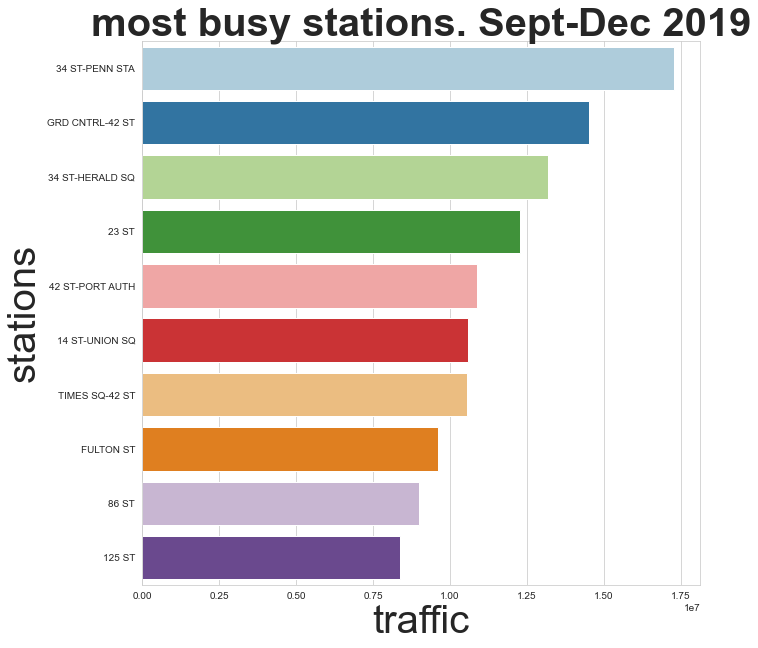

In [22]:
#Creating horizontal bar plots of 10 stations with highest number of entries in specified periods

plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', palette="Paired", data = top_10_stations_2019_sept_dec)
plt.title('most busy stations. Sept-Dec 2019', weight='bold', fontsize = 40)
plt.ylabel('stations', fontsize = 40)
plt.xlabel('traffic', fontsize = 40);
plt.savefig('most_busy_stations_Sept_Dec_2019', transparent=True, bbox_inches = 'tight')

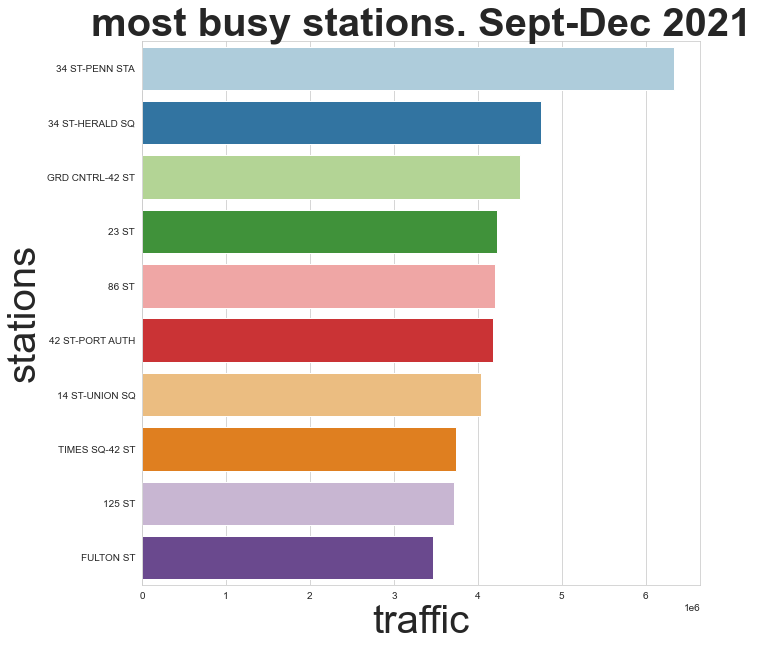

In [23]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', palette="Paired", data = top_10_stations_2021_sept_dec)
plt.title('most busy stations. Sept-Dec 2021', weight='bold', fontsize = 40)
plt.ylabel('stations', fontsize = 40)
plt.xlabel('traffic', fontsize = 40);
plt.savefig('most_busy_stations_Sept_Dec_2021', transparent=True, bbox_inches = 'tight')

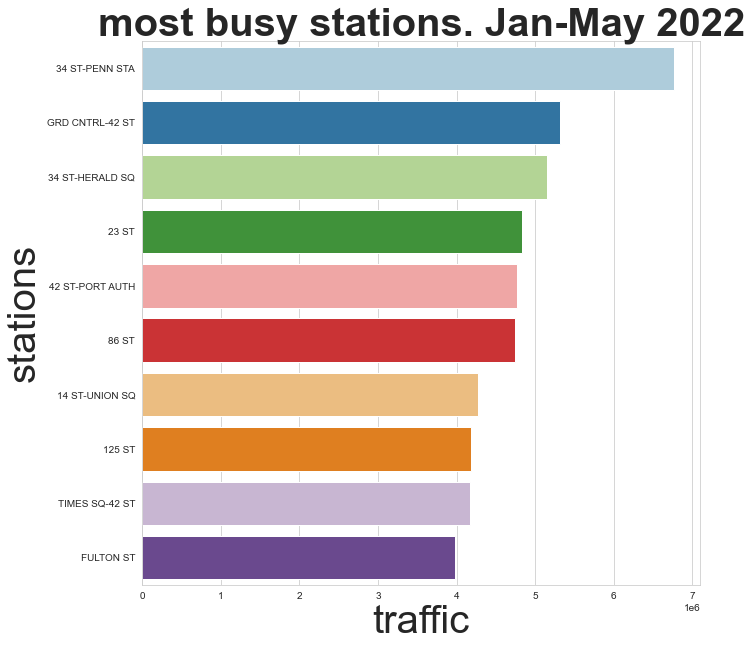

In [24]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', palette="Paired", data = top_10_stations_2022_jan_may)
plt.title('most busy stations. Jan-May 2022', weight='bold', fontsize = 40)
plt.ylabel('stations', fontsize = 40)
plt.xlabel('traffic', fontsize = 40);
plt.savefig('most_busy_stations_Jan_May_2022', transparent=True, bbox_inches = 'tight')

In [25]:
#As FULTON ST is at the bottom of the 2022 list, taking closer look and trying to identyfy trend

fulton_st_daily = turnstiles_daily[(turnstiles_daily["STATION"] == "FULTON ST") & (turnstiles_daily["DATE"].dt.date >= dt.datetime(2021, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 6, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
fulton_st_monthly = fulton_st_daily.groupby(fulton_st_daily.DATE.dt.month)['DAILY_ENTRIES'].sum().reset_index()
fulton_st_monthly

,DATE,DAILY_ENTRIES
0,1,661305.0
1,2,727034.0
2,3,908098.0
3,4,875768.0
4,5,810264.0
5,9,820322.0
6,10,897380.0
7,11,876731.0
8,12,866141.0


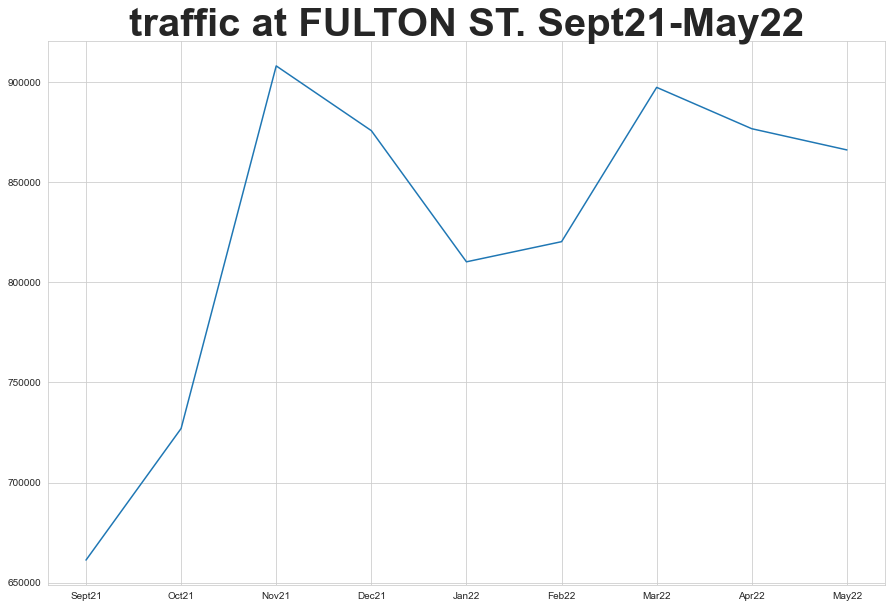

In [28]:
#Creating plot of FULTON ST traffic during Sept21-May22. As it is last one at top 10 list, checking how stable is the traffic

plt.figure(figsize=(15,10))
plt.plot(fulton_st_monthly.index, fulton_st_monthly['DAILY_ENTRIES'])
#plt.ylabel('traffic')
#plt.xlabel('Date')
plt.xticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8], ['Sept21', 'Oct21', 'Nov21', 'Dec21', 'Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22'])
plt.title('traffic at FULTON ST. Sept21-May22', weight='bold', fontsize = 40)
plt.savefig('traffic_at_FULTON_ST_Sept21-May22', transparent=True, bbox_inches = 'tight')


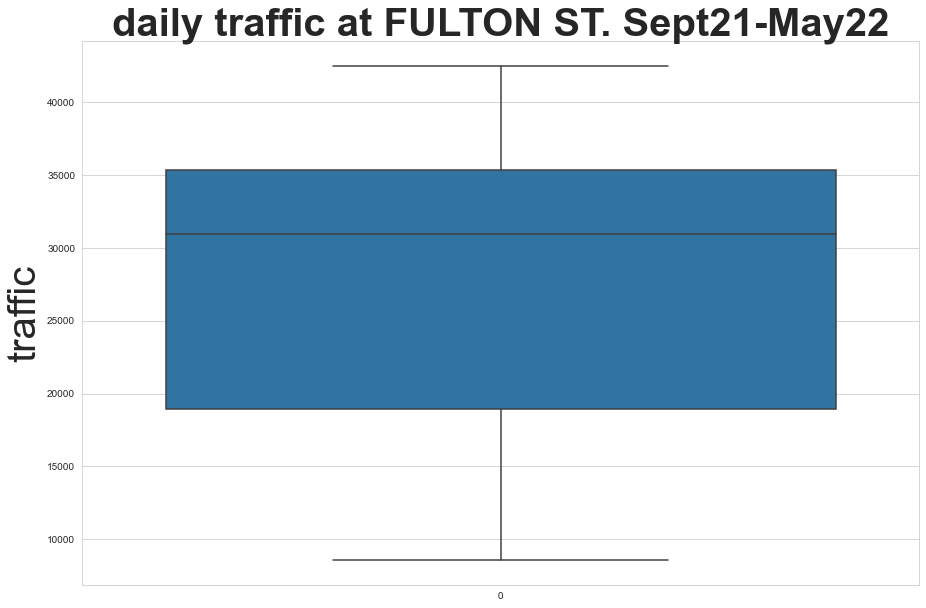

In [29]:
#Creating box plot of FULTON ST traffic during Sept21-May22. As it is last one at top 10 list, checking how stable is the traffic


plt.figure(figsize = [15,10])
sns.set_style("whitegrid")
plt.ylabel('traffic', fontsize = 40)
sns.boxplot(data = fulton_st_daily['DAILY_ENTRIES']);
plt.title('daily traffic at FULTON ST. Sept21-May22', weight='bold', fontsize = 40)
plt.savefig('daily_traffic_at_FULTON_ST_Sept21-May22', transparent=True, bbox_inches = 'tight')